![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
max_depth = None
num_pct = 10
max_features = None
min_gain = 0.001

#En este caso de regresión se utilizo MSE cambiando a la función Gini 

def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return ((y - y.mean())**2).mean()

def mse_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    
    return mse_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = mse_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=y.mean(), level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    y_prob = 1.0
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
       # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree


{'y_pred': 14508.073389276064,
 'y_prob': 1.0,
 'level': 0,
 'split': [0, 2014.0],
 'n_samples': 7031,
 'gain': 8706079.2690802,
 'sl': {'y_pred': 10234.929955947136,
  'y_prob': 1.0,
  'level': 1,
  'split': [0, 2012.0],
  'n_samples': 2270,
  'gain': 4019659.1499605672,
  'sl': {'y_pred': 8737.28071379547,
   'y_prob': 1.0,
   'level': 2,
   'split': [1, 97798.72727272728],
   'n_samples': 1457,
   'gain': 1109280.4742891928,
   'sl': {'y_pred': 9891.465256797583,
    'y_prob': 1.0,
    'level': 3,
    'split': -1,
    'n_samples': 662,
    'gain': 902634.9592679311},
   'sr': {'y_pred': 7776.186163522013,
    'y_prob': 1.0,
    'level': 3,
    'split': -1,
    'n_samples': 795,
    'gain': 619143.7020776966}},
  'sr': {'y_pred': 12918.90897908979,
   'y_prob': 1.0,
   'level': 2,
   'split': [1, 73300.81818181818],
   'n_samples': 813,
   'gain': 1307870.1875079386,
   'sl': {'y_pred': 13964.06546275395,
    'y_prob': 1.0,
    'level': 3,
    'split': -1,
    'n_samples': 443,
    '

In [ ]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecución de función tree_predict
y_pred = tree_predict(X_test, tree)

In [ ]:
#RSME Error
import math
MSE = np.square(np.subtract(y_test,y_pred)).mean()
MAE_manual_tree = np.mean(np.abs(y_test - y_pred))
rsme_manual_tree = math.sqrt(MSE)


print("Error cuadrático medio (RMSE):", MAE_manual_tree)
print("Error absoluto medio (MAE):", rsme_manual_tree)


Error cuadrático medio (RMSE): 1445.8091325887447
Error absoluto medio (MAE): 1921.0003286740268


Teniendo en cuentas la realización del código y la realización de la misma se considera que realizar el árbol de decisión de manera manual es poco eficiente para la correcta realización de la estimación de los datos. En este caso al ser una regresión se tomo el mismo formato que los laboratorios del árbol manual pero con MSE como párametro encambio de Gini. Se obtuvo que tiene una desviación promedio en los precios de los autos de 1.921 dólares con dichos resultados e indica que el modelo tiene un error promedio de 1.445 dólares en la predicción de los precios de los autos. De igual manera, nos parece poco eficiente según los errores (RMSE y MAE) comparado con otros realizados en este taller.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)

np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred_bag = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_bag = X_train.iloc[sample]
    y_train_bag = y_train.iloc[sample]
    treereg.fit(X_train_bag, y_train_bag)
    y_pred_bag.iloc[:,i] = treereg.predict(X_test)
    
y_pred_bag

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [ ]:
from sklearn.metrics import mean_squared_error
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred_bag.iloc[:,i], y_test)))

print(y_pred_bag.mean(axis=1))

Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2136.3519863123465
Árbol  2 tiene un error:  2122.718759132052
Árbol  3 tiene un error:  2087.278992468617
Árbol  4 tiene un error:  2168.518742842026
Árbol  5 tiene un error:  2113.8811455834793
Árbol  6 tiene un error:  2127.933470769012
Árbol  7 tiene un error:  2184.414847251443
Árbol  8 tiene un error:  2138.1071697514985
Árbol  9 tiene un error:  2132.097520859104
257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: float64


In [22]:
# Error al promediar las predicciones de todos los árboles
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mse_bag_manual = mean_squared_error(y_test, y_pred_bag.mean(axis=1))
MAE_bag_manual = mean_absolute_error(y_test, y_pred_bag.mean(axis=1))
RMSE_bag_manual = np.sqrt(mse_bag_manual)

print("Error cuadrático medio (RMSE):", RMSE_bag_manual)
print("Error absoluto medio (MAE):", MAE_bag_manual)

Error cuadrático medio (RMSE): 1796.4355868399332
Error absoluto medio (MAE): 1340.0160739030025


Se obtuvo que tiene una desviación promedio en los precios de los autos de 1.340 dólares con dichos resultados e indica que el modelo tiene un error promedio de 1.796 dólares en la predicción de los precios de los autos. En este caso comparado con el árbol de decisión se puede ver que se mejoro en cuento el valor del MAE unos 128 dolares pero con respecto a el RMSE este aumento 351 dandonos a entender que puede existir un modelo mejor. 

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [19]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


bagreg = BaggingRegressor(DecisionTreeRegressor(max_features = 'log2'), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=1)
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
mse_BG_sk = mean_squared_error(y_test, y_pred)
MAE_BG_sk = mean_absolute_error(y_test, y_pred)
RMSE_BG_sk = np.sqrt(mse_BG_sk)

print("Error cuadrático medio (RMSE):", RMSE_BG_sk)
print("Error absoluto medio (MAE):", MAE_BG_sk)

Error cuadrático medio (RMSE): 1824.7000069648657
Error absoluto medio (MAE): 1361.8777493561897


Se obtuvo que tiene una desviación promedio en los precios de los autos de 1.361 dólares con dichos resultados e indica que el modelo tiene un error promedio de 1.824 dólares en la predicción de los precios de los autos. En este caso comparado con el bagging manual se puede ver que se aumento el valor del MAE unos 61 dolares y con respecto a el RMSE este aumento 28 dolares teniendo mejor desempeño el modelo anterior.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Variación de hiper parametros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}

# Creamos el modelo Random Forest
rf = RandomForestRegressor(random_state=42)

# Buscamos el mejor conjunto de hiperparámetros mediante Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluamos el modelo en el conjunto de prueba
y_pred = grid_search.predict(X_test)
rmse_RF = mean_squared_error(y_test, y_pred, squared=False)
mae_RF = mean_absolute_error(y_test, y_pred)

# Imprimimos el RMSE y el MAE
print("Error cuadrático medio (RMSE):", rmse_RF)
print("Error absoluto medio (MAE):", mae_RF)


Mejores hiperparámetros: {'max_depth': 10, 'n_estimators': 100}
Error cuadrático medio (RMSE): 1583.6492233928598
Error absoluto medio (MAE): 1164.5609588027446


Se obtuvo que tiene una desviación promedio en los precios de los autos de 1.164 dólares con dichos resultados e indica que el modelo tiene un error promedio de 1.583 dólares en la predicción de los precios de los autos. En este caso comparado con el bagging con libreria que a sido el mejor hasta ahora se puede ver que se disminuyo el valor del MAE unos 197 dolares y con respecto a el RMSE disminuyo 241 dolares teniendo mejor desempeño el modelo anterior.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

El mejor valor de max_depth es: 8


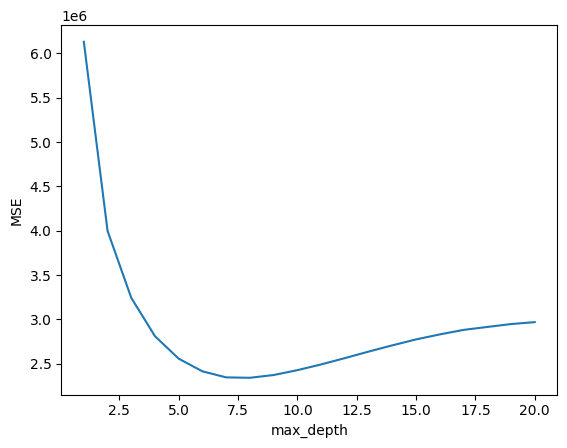

In [25]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 21)

# Definición de lista para almacenar el MSE promedio por valor de max_depth
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestRegressor(max_depth=depth, random_state=1, n_jobs=-1)
    mse_scores.append(-1 * cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

optimal_max_depth = depth_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de max_depth es:", optimal_max_depth)


**max_depth**: El parámetro controla la profundidad máxima del árbol de decisión en cada estimador de Random Forest. Un valor más alto de "max_depth" permite que el modelo se ajuste más a los datos de entrenamiento, pero también puede aumentar la posibilidad de sobreajuste. Por lo tanto, un valor óptimo de "max_depth" en este caso  es de 8, en donde tenemos el valor minimo de la curva.

El mejor valor de max_features es: 4


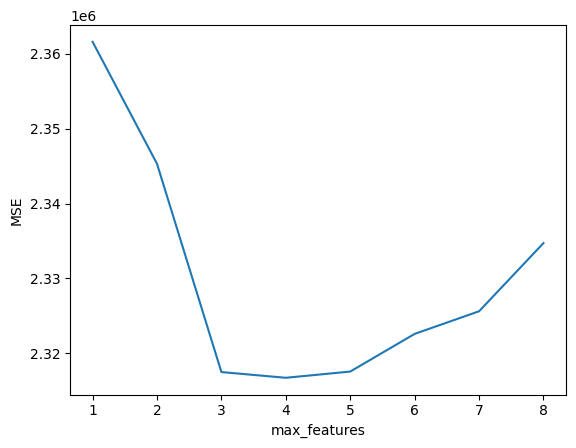

In [26]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1])

# Definición de lista para almacenar el MSE promedio para cada valor de max_features
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestRegressor(max_features=feature, max_depth=optimal_max_depth ,random_state=1, n_jobs=-1)
    mse_scores.append(-1 * cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, mse_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')

optimal_max_features = feature_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de max_features es:", optimal_max_features)

**max_features**: El parámetro controla el número máximo de características que se consideran para dividir un nodo en el árbol de decisión. Un valor más bajo de  reduce la complejidad del modelo y puede ayudar a prevenir el sobreajuste, mientras que un valor más alto puede mejorar el rendimiento del modelo en conjuntos de datos con muchas características relevantes, en este caso se selecciona el optimo

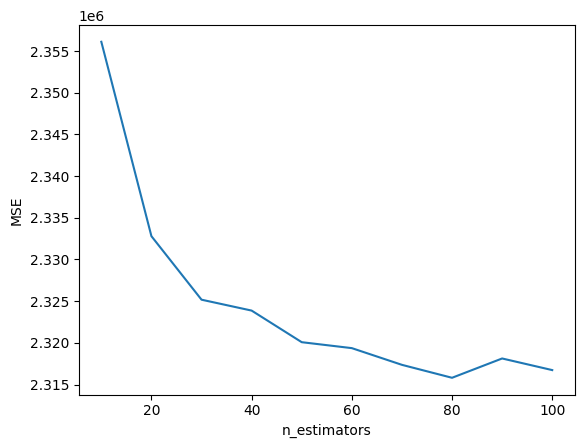

El mejor valor de n_estimators es: 80


In [27]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 101, 10)

# Definición de lista para almacenar el MSE promedio para cada valor de n_estimators
mse_scores = []

# Iterar sobre diferentes valores de n_estimators
for estimator in estimator_range:
    # Crear un modelo de regresión random forest con el número de estimadores dado y otros parámetros fijos
    rf = RandomForestRegressor(n_estimators=estimator ,max_features=optimal_max_features, max_depth=optimal_max_depth ,random_state=1, n_jobs=-1)
    # Calcular el MSE promedio utilizando 10-fold cross-validation
    mse_scores.append(-1 * cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.show()

# Obtener el valor óptimo de n_estimators con el menor MSE promedio
optimal_n_estimators = estimator_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de n_estimators es:", optimal_n_estimators)

**n_estimators**: controla el número de árboles que se construyen en el modelo de Random Forest. Un valor más alto de estimadores puede mejorar el rendimiento del modelo, pero también aumenta el costo computacional, en este caso vemos que se alcanza el menor cuando la cantidad de estimadores es 80

In [29]:
rf = RandomForestRegressor(n_estimators=optimal_n_estimators ,max_features=optimal_max_features, max_depth=optimal_max_depth ,random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

b_rmse = mean_squared_error(y_test, y_pred, squared=False)
b_mae = mean_absolute_error(y_test, y_pred)

# Imprimimos el RMSE y el MAE
print("Error cuadrático medio (RMSE):", b_rmse)
print("Error absoluto medio (MAE):", b_mae)

Error cuadrático medio (RMSE): 1550.0807439441892
Error absoluto medio (MAE): 1138.942239585836


Después de realizar la búsqueda de los mejores parámetros para el modelo, se observa una mejora en las métricas de evaluación, tanto en el RMSE como en el MAE. En el primer modelo, se obtuvo una desviación promedio en los precios de los autos de 1.164 dólares, mientras que con el modelo ajustado con los mejores parámetros se logró reducir esta desviación a 1.138 dólares. Esto significa que se ha logrado una mejora de 26 dólares en promedio en la precisión del modelo en términos de la desviación de las predicciones con respecto a los precios reales de los autos usados.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [30]:
from xgboost import XGBRegressor
XG_reg = XGBRegressor()

XG_reg.fit(X_train, y_train)

y_pred= XG_reg.predict(X_test)

mse_XG = mean_squared_error(y_test, y_pred)
MAE_XG = mean_absolute_error(y_test, y_pred)
RMSE_XG = np.sqrt(mse_XG)
MAPE_XG = mean_absolute_percentage_error(y_test, y_pred)

print("Error cuadrático medio (RMSE):", RMSE_XG)
print("Error absoluto medio (MAE):", MAE_XG)

Error cuadrático medio (RMSE): 1621.4197004256812
Error absoluto medio (MAE): 1186.634392366123


Se obtuvo que tiene una desviación promedio en los precios de los autos de 1.186 dólares con dichos resultados e indica que el modelo tiene un error promedio de 1.621 dólares en la predicción de los precios de los autos. En este caso comparado con el modelo anterior que a sido el mejor hasta ahora se puede ver que aumento el valor del MAE unos 48 dolares y con respecto a el RMSE aumento 71 dolares teniendo menor desempeño el modelo anterior.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

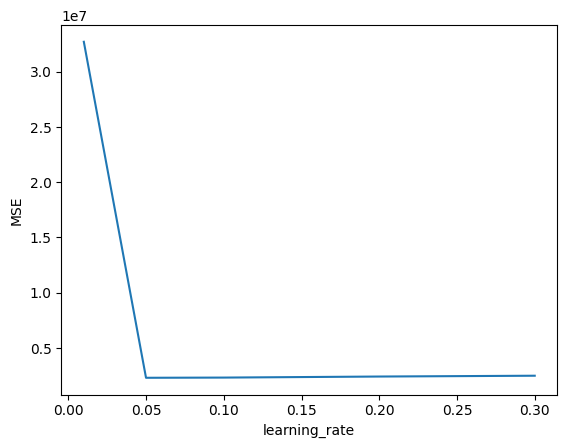

El mejor valor de learning_rate es: 0.05


In [31]:
# Creación de lista de valores para iterar sobre diferentes valores de learning_rate
learning_rate_range = [0.01, 0.05, 0.1, 0.2, 0.3]

# Definición de lista para almacenar el MSE promedio para cada valor de learning_rate
mse_scores = []

# Iterar sobre diferentes valores de learning_rate
for lr in learning_rate_range:
    # Crear un modelo de regresión XGBoost con el learning_rate dado y otros parámetros fijos
    xgb = XGBRegressor(learning_rate=lr)
    # Calcular el MSE promedio utilizando 10-fold cross-validation
    mse_scores.append(-1 * cross_val_score(xgb, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs el valor de learning_rate
plt.plot(learning_rate_range, mse_scores)
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.show()

# Obtener el valor óptimo de learning_rate con el menor MSE promedio
optimal_learning_rate = learning_rate_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de learning_rate es:", optimal_learning_rate)

**learning_rate**: Este parámetro controla la tasa de aprendizaje del modelo. Un valor más pequeño de learning_rate, como 0.05 en este caso, implica una actualización más lenta de los pesos y puede resultar en un modelo más conservador con menos riesgo de sobreajuste.

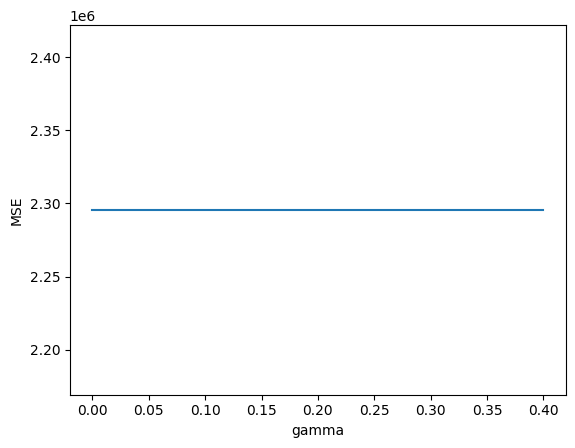

El mejor valor de gamma es: 0


In [32]:
# Creación de lista de valores para iterar sobre diferentes valores de gamma
gamma_range = [0, 0.1, 0.2, 0.3, 0.4]

# Definición de lista para almacenar el MSE promedio para cada valor de gamma
mse_scores = []

# Iterar sobre diferentes valores de gamma
for gamma_val in gamma_range:
    # Crear un modelo de regresión XGBoost con el gamma dado y otros parámetros fijos
    xgb = XGBRegressor(gamma=gamma_val,learning_rate=optimal_learning_rate )
    # Calcular el MSE promedio utilizando 10-fold cross-validation
    mse_scores.append(-1 * cross_val_score(xgb, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs el valor de gamma
plt.plot(gamma_range, mse_scores)
plt.xlabel('gamma')
plt.ylabel('MSE')
plt.show()

# Obtener el valor óptimo de gamma con el menor MSE promedio
optimal_gamma = gamma_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de gamma es:", optimal_gamma)

**gamma**: Este parámetro controla la reducción mínima requerida en la función de pérdida para realizar una partición en un nodo del árbol. Un valor mayor de gamma permite una mayor reducción de la función de pérdida antes de realizar una partición, lo que resulta en árboles más pequeños y menos complejos. Un valor de 0.0 en este caso indica que no se aplica ninguna restricción en la creación de nuevos nodos en los árboles.

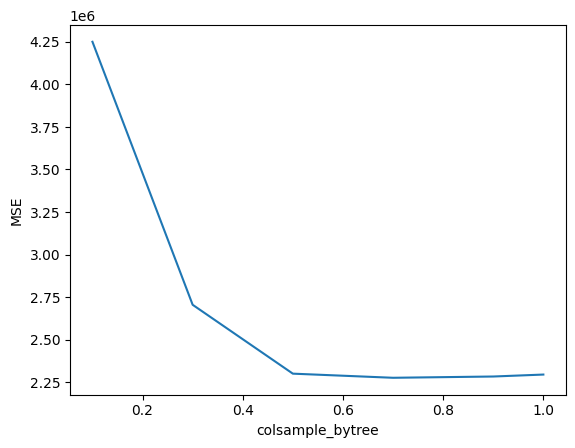

El mejor valor de colsample_bytree es: 0.7


In [33]:
# Creación de lista de valores para iterar sobre diferentes valores de colsample_bytree
colsample_bytree_range = [0.1, 0.3, 0.5, 0.7, 0.9,1.0]

# Definición de lista para almacenar el MSE promedio para cada valor de colsample_bytree
mse_scores = []

# Iterar sobre diferentes valores de colsample_bytree
for colsample_bytree_val in colsample_bytree_range:
    # Crear un modelo de regresión XGBoost con el colsample_bytree dado y otros parámetros fijos
    xgb = XGBRegressor(colsample_bytree=colsample_bytree_val, gamma=optimal_gamma,learning_rate=optimal_learning_rate)
    # Calcular el MSE promedio utilizando 10-fold cross-validation
    mse_scores.append(-1 * cross_val_score(xgb, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs el valor de colsample_bytree
plt.plot(colsample_bytree_range, mse_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('MSE')
plt.show()

# Obtener el valor óptimo de colsample_bytree con el menor MSE promedio
optimal_colsample_bytree = colsample_bytree_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de colsample_bytree es:", optimal_colsample_bytree)

**colsample_bytree**: Este parámetro controla la fracción de características que se utiliza para construir cada árbol en el modelo. Un valor de 1.0 indica que se utilizan todas las características disponibles, mientras que un valor menor a 1.0, como 0.7 en este caso, indica que se selecciona aleatoriamente el 70% de las características para construir cada árbol. Reducir la fracción de características puede ayudar a reducir la correlación entre los árboles y mejorar la generalización del modelo.

In [34]:
xg = XGBRegressor(colsample_bytree=optimal_colsample_bytree, gamma=optimal_gamma,learning_rate=optimal_learning_rate)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

b_rmse_xg = mean_squared_error(y_test, y_pred, squared=False)
b_mae_xg = mean_absolute_error(y_test, y_pred)

# Imprimimos el RMSE y el MAE
print("Error cuadrático medio (RMSE):", b_rmse_xg)
print("Error absoluto medio (MAE):", b_mae_xg)

Error cuadrático medio (RMSE): 1546.1578633018344
Error absoluto medio (MAE): 1130.6114840254222


Después de realizar la búsqueda de los mejores parámetros para el modelo, se observa una mejora en las métricas de evaluación, tanto en el RMSE como en el MAE. En el primer modelo, se obtuvo una desviación promedio en los precios de los autos de 1.186 dólares, mientras que con el modelo ajustado con los mejores parámetros se logró reducir esta desviación a 1.130 dólares. Esto significa que se ha logrado una mejora de 56 dólares en promedio en la precisión del modelo en términos de la desviación de las predicciones con respecto a los precios reales de los autos usados.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

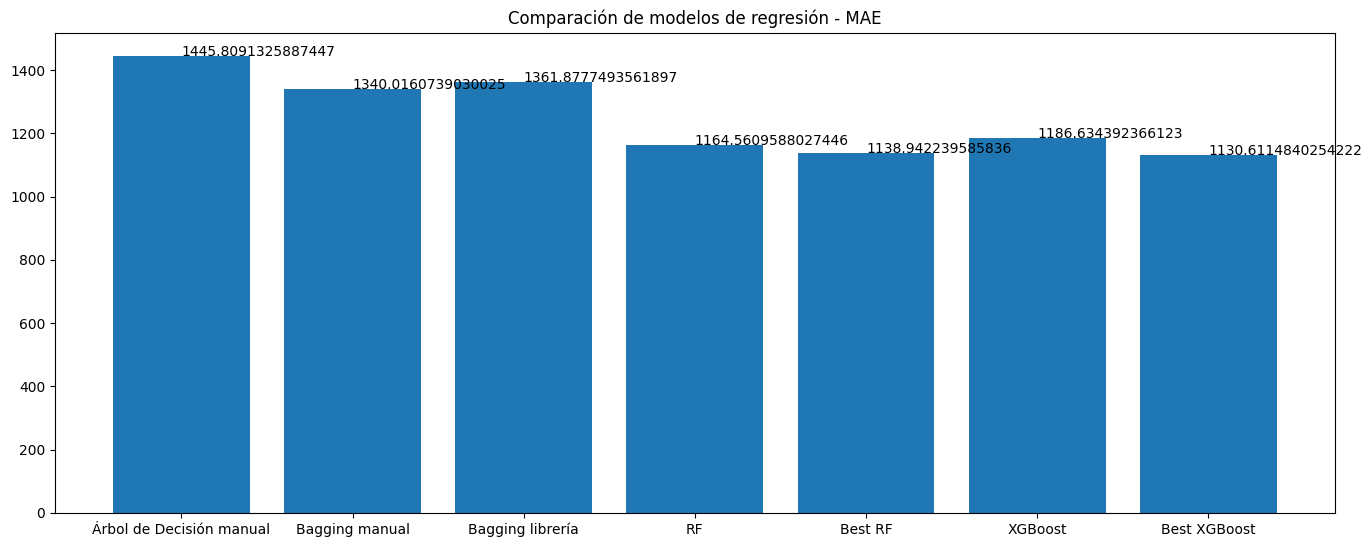

In [37]:
# Datos para el gráfico de barras
ejeX = ['Árbol de Decisión manual','Bagging manual', 'Bagging librería', 'RF', 'Best RF', 'XGBoost', 'Best XGBoost']
ejeY = [MAE_manual_tree,MAE_bag_manual, MAE_BG_sk, mae_RF, b_mae, MAE_XG, b_mae_xg]

# Crear la figura y el eje, ajustando el ancho de la figura
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ax.set_title("Comparación de modelos de regresión - MAE")

# Crear la gráfica de barras
ax.bar(ejeX, ejeY)

# Función para agregar etiquetas a las barras
def addlabels(x, y, plot):
    for i in range(len(x)):
        plot.text(i, y[i], y[i])

# Agregar etiquetas a las barras
addlabels(ejeX, ejeY, plt)

# Mostrar el gráfico
plt.show()

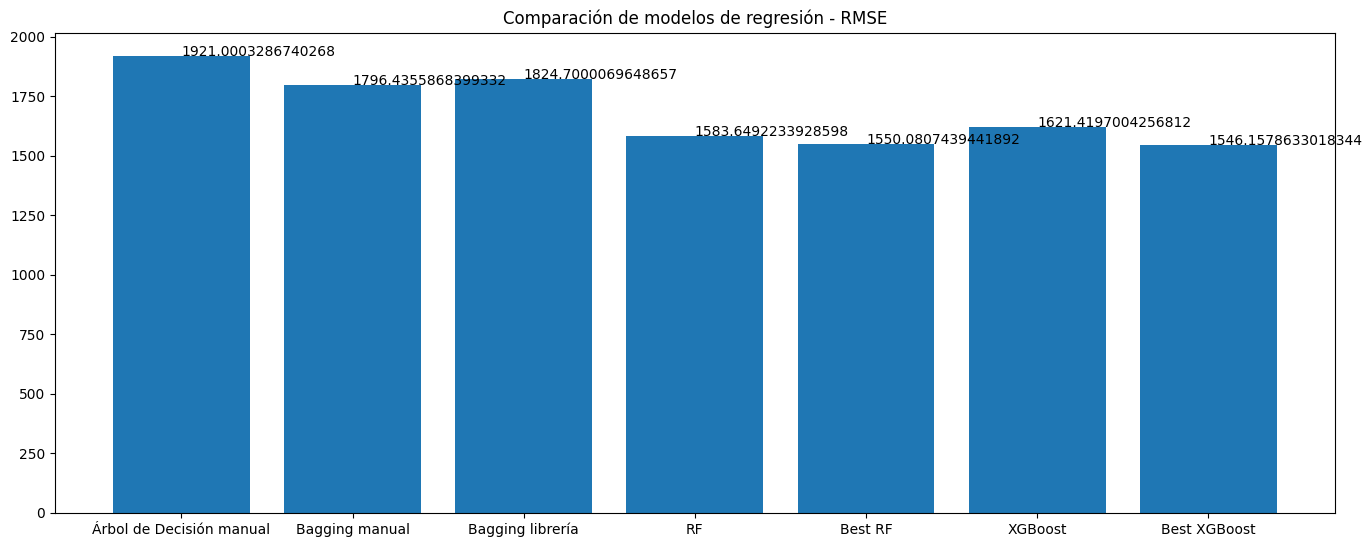

In [38]:
# Datos para el gráfico de barras
ejeX = ['Árbol de Decisión manual','Bagging manual', 'Bagging librería', 'RF', 'Best RF', 'XGBoost', 'Best XGBoost']
ejeY = [rsme_manual_tree,RMSE_bag_manual, RMSE_BG_sk, rmse_RF, b_rmse, RMSE_XG, b_rmse_xg]

# Crear la figura y el eje, ajustando el ancho de la figura
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ax.set_title("Comparación de modelos de regresión - RMSE")

# Crear la gráfica de barras
ax.bar(ejeX, ejeY)

# Función para agregar etiquetas a las barras
def addlabels(x, y, plot):
    for i in range(len(x)):
        plot.text(i, y[i], y[i])

# Agregar etiquetas a las barras
addlabels(ejeX, ejeY, plt)

# Mostrar el gráfico
plt.show()

Teniendo en cuenta todos los métodos realizados en el taller se puede ver que el mejor desempeño teniendo en cuenta Error cuadrático medio (RMSE) y Error absoluto medio (MAE) es el obtenido en la calibracion de los párametros de XGBoost obtuviendo 1546 y 1130 respectivamente. Si se realiza la comparación con los resultados delmétodo menos eficiente (Árbol de decisión Manual) tendiendo los resultados 1921 y 1445 se puede inferir  que se ha logrado una mejora de 315 dólares en promedio en la precisión del modelo en términos de la desviación de las predicciones con respecto a los precios reales de los autos usados y 375 con respecto a el error promedio con respecto a la predicción de los precios de los autos.
